# Лабораторная работа №4 Реализация алгоритма Policy Iteration.

**Цель лабораторной работы:** ознакомление с базовыми методами обучения с подкреплением.

**Задание:**

* На основе рассмотренного на лекции примера реализуйте алгоритм Policy Iteration для любой среды обучения с подкреплением (кроме рассмотренной на лекции среды Toy Text / Frozen Lake) из библиотеки Gym (или аналогичной библиотеки).

In [4]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
from pprint import pprint

def main():
    state, action = 0, 0
    env = gym.make("CliffWalking-v0")
    print('Пространство состояний:')
    pprint(env.observation_space)
    print()
    print('Пространство действий:')
    pprint(env.action_space)
    print()
    print('Диапазон наград:')
    pprint(env.reward_range)
    print()
    print('Вероятности для 0 состояния и 0 действия:')
    pprint(env.P[state][action])
    print()
    print('Вероятности для 0 состояния:')
    pprint(env.P[state])


if __name__ == '__main__':
    main()

Пространство состояний:
Discrete(48)

Пространство действий:
Discrete(4)

Диапазон наград:
(-inf, inf)

Вероятности для 0 состояния и 0 действия:
[(1.0, 0, -1, False)]

Вероятности для 0 состояния:
{0: [(1.0, 0, -1, False)],
 1: [(1.0, 1, -1, False)],
 2: [(1.0, 12, -1, False)],
 3: [(1.0, 0, -1, False)]}


In [5]:
class PolicyIterationAgent:
    '''
    Класс, эмулирующий работу агента
    '''

    def __init__(self, env):
        self.env = env
        # Пространство состояний
        self.observation_dim = 48
        # Массив действий в соответствии с документацией
        # https://www.gymlibrary.dev/environments/toy_text/frozen_lake/
        self.actions_variants = np.array([0, 1, 2, 3])
        # Задание стратегии (политики)
        # Карта 4х4 и 6 возможных действий
        self.policy_probs = np.full((self.observation_dim, len(self.actions_variants)), 0.25)
        # Начальные значения для v(s)
        self.state_values = np.zeros(shape=(self.observation_dim))
        # Начальные значения параметров
        self.maxNumberOfIterations = 1000
        self.theta = 1e-6
        self.gamma = 0.99

    def print_policy(self):
        '''
        Вывод матриц стратегии
        '''
        print('Стратегия:')
        pprint(self.policy_probs)

    def policy_evaluation(self):
        '''
        Оценивание стратегии 
        '''
        # Предыдущее значение функции ценности
        valueFunctionVector = self.state_values
        for iterations in range(self.maxNumberOfIterations):
            # Новое значение функции ценности
            valueFunctionVectorNextIteration = np.zeros(shape=(self.observation_dim))
            # Цикл по состояниям
            for state in range(self.observation_dim):
                # Вероятности действий
                action_probabilities = self.policy_probs[state]
                # Цикл по действиям
                outerSum = 0
                for action, prob in enumerate(action_probabilities):
                    innerSum = 0
                    # Цикл по вероятностям действий
                    for probability, next_state, reward, isTerminalState in self.env.P[state][action]:
                        innerSum = innerSum + probability * (reward + self.gamma * self.state_values[next_state])
                    outerSum = outerSum + self.policy_probs[state][action] * innerSum
                valueFunctionVectorNextIteration[state] = outerSum
            if (np.max(np.abs(valueFunctionVectorNextIteration - valueFunctionVector)) < self.theta):
                # Проверка сходимости алгоритма
                valueFunctionVector = valueFunctionVectorNextIteration
                break
            valueFunctionVector = valueFunctionVectorNextIteration
        return valueFunctionVector

    def policy_improvement(self):
        '''
        Улучшение стратегии 
        '''
        qvaluesMatrix = np.zeros((self.observation_dim, len(self.actions_variants)))
        improvedPolicy = np.zeros((self.observation_dim, len(self.actions_variants)))
        # Цикл по состояниям
        for state in range(self.observation_dim):
            for action in range(len(self.actions_variants)):
                for probability, next_state, reward, isTerminalState in self.env.P[state][action]:
                    qvaluesMatrix[state, action] = qvaluesMatrix[state, action] + probability * (
                                reward + self.gamma * self.state_values[next_state])

            # Находим лучшие индексы
            bestActionIndex = np.where(qvaluesMatrix[state, :] == np.max(qvaluesMatrix[state, :]))
            # Обновление стратегии
            improvedPolicy[state, bestActionIndex] = 1 / np.size(bestActionIndex)
        return improvedPolicy

    def policy_iteration(self, cnt):
        '''
        Основная реализация алгоритма
        '''
        policy_stable = False
        for i in range(1, cnt + 1):
            self.state_values = self.policy_evaluation()
            self.policy_probs = self.policy_improvement()
        print(f'Алгоритм выполнился за {i} шагов.')


def play_agent(agent):
    env2 = gym.make('CliffWalking-v0', render_mode='human')
    state = env2.reset()[0]
    done = False
    while not done:
        p = agent.policy_probs[state]
        if isinstance(p, np.ndarray):
            action = np.random.choice(len(agent.actions_variants), p=p)
        else:
            action = p
        next_state, reward, terminated, truncated, _ = env2.step(action)
        env2.render()
        state = next_state
        if terminated or truncated:
            done = True


def main():
    # Создание среды
    env = gym.make('CliffWalking-v0')
    env.reset()
    # Обучение агента
    agent = PolicyIterationAgent(env)
    agent.print_policy()
    agent.policy_iteration(1000)
    agent.print_policy()
    # Проигрывание сцены для обученного агента
    play_agent(agent)


if __name__ == '__main__':
    main()

Стратегия:
array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],

: 

В начале алгоритма

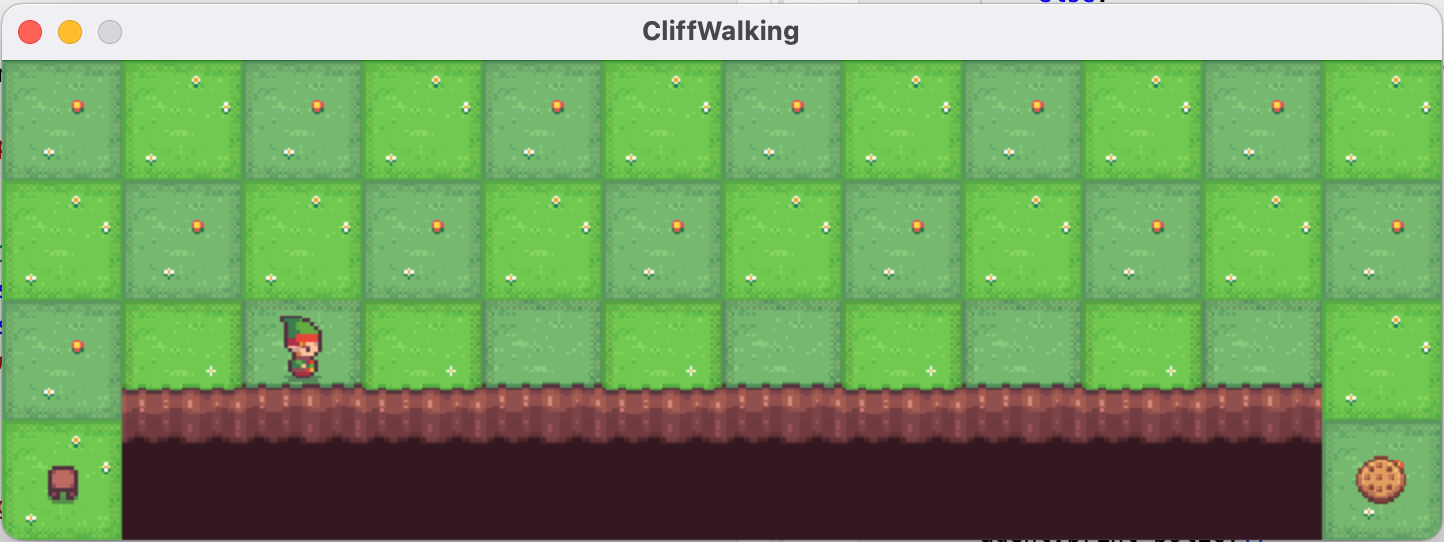

В конце

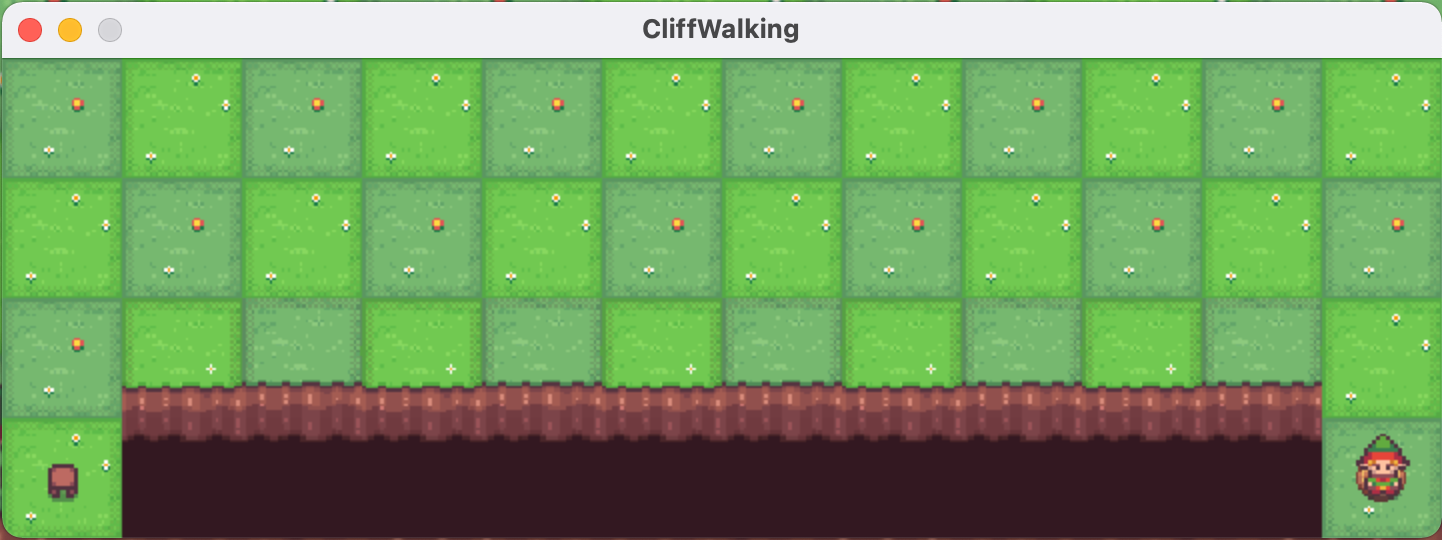

## Вывод
Методика Policy Iteration позволяет, имея матрицу состояний и вероятностей действий, итеративно улучшать стратегию переходов между состояниями. В данной ЛР улучшение достигается за счёт штрафа за лишние переходы и штрафов за взятие и высадку пассажира вне ожидаемой зоны.
Таким образом, все переходы будут равнозначны до момента нахождения тортика.
